In [55]:
import numpy as np
import pandas as pd,os
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import scikit_posthocs as sp
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from library.utils import read_data

In [56]:
filtered = pd.read_csv("All_filter_MCC.csv",header=[0,1],index_col=0)
Clean = pd.read_csv("Clean.csv",header=[0,1,2],index_col=0)
Clean = Clean.drop(columns=['pr_rec_score'],level=2).droplevel(2,axis=1) ##pr_rec_score, matthews_corrcoef
Noisy = pd.read_csv("Noisy.csv",header=[0,1,2],index_col=0)
Noisy = Noisy.drop(columns=['pr_rec_score'],level=2).droplevel(2,axis=1)
filtered.shape,Clean.shape,Noisy.shape

((32, 60), (32, 30), (32, 30))

## Dataset Characteristic vs MCC

In [57]:
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]

In [67]:
dependent = Noisy
dependent.shape

(32, 30)

In [68]:
df = pd.DataFrame(columns=['noise','FP','FN','TP','TN','nIR','IR','PR','Rec','MCC'])
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,stats=False)
    noise = (y_noisy!=y_real).sum()/len(y_noisy)
    tn, fp, fn, tp = confusion_matrix(y_real,y_noisy).ravel()
    nIR = (y_noisy==0).sum()/y_noisy.sum()
    IR = (y_real==0).sum()/y_real.sum()
    pr = precision_score(y_real,y_noisy)
    rec = recall_score(y_real,y_noisy)
    for col in dependent.columns:
        df.loc[len(df)] = [noise,fp,fn,tp,tn,nIR,IR,pr,rec]+[dependent.loc[d,col]]
df.shape,df.isna().sum().sum()

((960, 10), 0)

In [78]:
dataStat = df.loc[::dependent.shape[1]].drop(columns=['MCC'])
dataStat.corr()

,noise,FP,FN,TP,TN,nIR,IR,PR,Rec
noise,1.000000,0.003989,0.530921,0.394874,-0.604112,-0.510341,-0.745125,0.334167,-0.151932
FP,0.003989,1.000000,-0.394866,0.090790,0.245745,-0.319471,0.383242,-0.688314,0.363664
FN,0.530921,-0.394866,1.000000,0.405652,-0.003925,0.188557,-0.418024,0.644037,-0.697640
TP,0.394874,0.090790,0.405652,1.000000,0.035472,-0.341250,-0.268020,0.534875,0.105204
TN,-0.604112,0.245745,-0.003925,0.035472,1.000000,0.619920,0.808073,-0.189593,-0.166302
nIR,-0.510341,-0.319471,0.188557,-0.341250,0.619920,1.000000,0.419101,0.013025,-0.574179
IR,-0.745125,0.383242,-0.418024,-0.268020,0.808073,0.419101,1.000000,-0.541347,0.238465
PR,0.334167,-0.688314,0.644037,0.534875,-0.189593,0.013025,-0.541347,1.000000,-0.302146
Rec,-0.151932,0.363664,-0.697640,0.105204,-0.166302,-0.574179,0.238465,-0.302146,1.000000


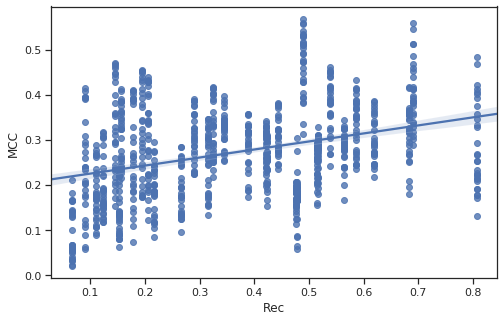

In [70]:
plt.figure(figsize=(8,5))
sns.regplot(x='Rec',y='MCC',data=df,robust=False,order=1);

In [71]:
for col in df:
    if col=='MCC': continue
    print(col)
    print(pg.corr(df[col],df['MCC'],method='percbend'),'\n\n')

noise
            n      r         CI95%     r2  adj_r2         p-val  power
percbend  960  0.272  [0.21, 0.33]  0.074   0.072  8.746705e-18    1.0 


FP
            n      r           CI95%     r2  adj_r2     p-val  power
percbend  960 -0.107  [-0.17, -0.04]  0.011   0.009  0.000934  0.912 


FN
            n      r          CI95%     r2  adj_r2     p-val  power
percbend  960 -0.137  [-0.2, -0.07]  0.019   0.017  0.000021  0.989 


TP
            n      r         CI95%     r2  adj_r2         p-val  power
percbend  960  0.277  [0.22, 0.33]  0.077   0.075  2.496149e-18    1.0 


TN
            n      r           CI95%     r2  adj_r2         p-val  power
percbend  960 -0.517  [-0.56, -0.47]  0.267   0.266  8.824203e-67    1.0 


nIR
            n      r           CI95%     r2  adj_r2         p-val  power
percbend  960 -0.438  [-0.49, -0.38]  0.191    0.19  3.710683e-46    1.0 


IR
            n      r           CI95%     r2  adj_r2         p-val  power
percbend  960 -0.377  [-0.43, -0.3

In [86]:
df['IR_disc'] = df['nIR'] < df['nIR'].median()

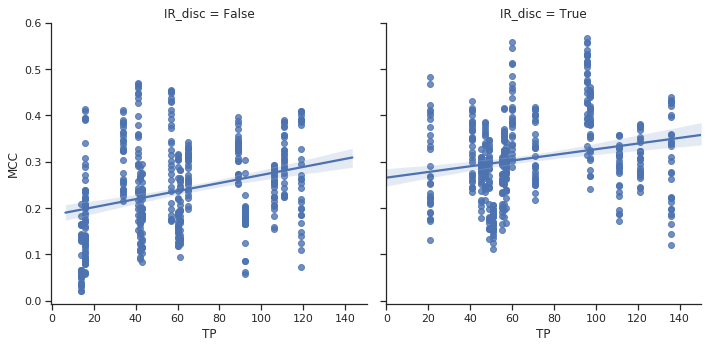

In [92]:
sns.lmplot(x='TP',y='MCC',col='IR_disc',data=df,robust=False,order=1);

In [54]:
a = list(range(100))
a[::5]

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]